In [1]:
import os
from pathlib import Path
import zipfile, kaggle

import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

In [2]:
path = Path('../../deep-learning/titanic')


In [3]:
df = pd.read_csv(path/'train.csv')

In [4]:
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## EDA

<Axes: >

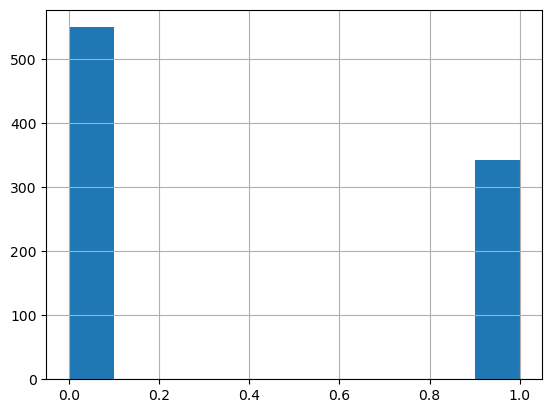

In [5]:
#understanding the target
df['Survived'].hist()

In [6]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [7]:
df.fillna(modes, inplace=True) #Filling in missing values with the mode

In [8]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [9]:
df.describe()
# Fare can get very large

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
#transform hist to prevent long postive skew from affecting results
df['LogFare'] = np.log(df['Fare'] + 1)

<Axes: >

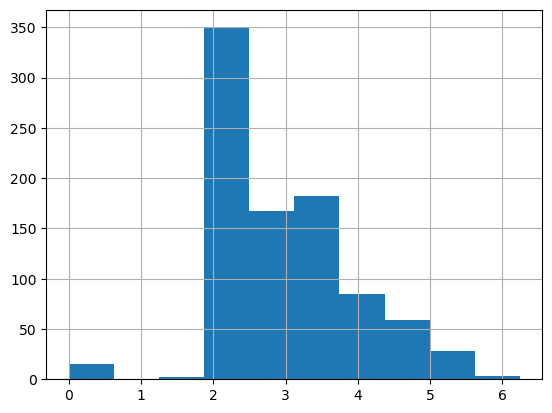

In [11]:
df['LogFare'].hist()

In [12]:
#Making dummies for every categorical value

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
 12  LogFare      891 non-null    float64
dtypes: float64(3), int64(5), object(5)
memory usage: 90.6+ KB


In [14]:
df = pd.get_dummies(df, columns = ['Sex', 'Pclass', 'Embarked'], dtype = 'float')
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [15]:
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head(10)

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
6,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
9,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


## Gradient Descent

In [16]:
from torch import tensor

In [63]:
t_dep = tensor(df['Survived'])

In [65]:
indep_cols = indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols
t_indep = tensor(df[indep_cols].values, dtype = torch.float)
vals, indices = t_indep.max(dim = 0)
t_indep = t_indep / vals

In [20]:
torch.manual_seed(17)

In [66]:
n_coeffs = t_indep.size()[1]


In [68]:
def init_weights(n_coeffs):
    return (torch.randn(n_coeffs) - 0.5)
def calc_loss(weights, t_indep, t_dep):
    preds = (weights*t_indep).sum(axis = 1)
    return torch.abs(t_dep - preds).mean()

In [69]:
w = init_weights(n_coeffs)
loss = calc_loss(w, t_indep, t_dep)
loss

tensor(3.4236)

In [70]:
# from fastai.data.transforms import RandomSplitter

# t_split, val_split = RandomSplitter(seed = 17)(df)

In [ ]:
# trn_

In [77]:
def update_coeffs(weights, lr):
    return weights.sub_(weights.grad*lr)
    
def init_coeffs(size):
    return (torch.randn(size) -0.5).requires_grad_()

def show_coeffs():
    return dict(zip(t_indep, weights))

def one_epoch(weights, lr):
    loss = calc_loss(weights, preds, t_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(weights, lr)
    print(f"{loss:.3f}", end = "; ")
    

In [78]:
def train_model(epochs = 25, lr = 0.01):
    weights = init_coeffs(t_indep.size()[1])
    for i in range(epochs):
        one_epoch(weights, lr)
    return weights

In [79]:
train_model()

RuntimeError: The size of tensor a (12) must match the size of tensor b (891) at non-singleton dimension 0

In [80]:
n_coeff = t_indep.shape[1]
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad*lr)

def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, t_indep, t_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

def init_coeffs():
    ''' Initialises random coefficients'''
    return (torch.rand(n_coeff)-0.5).requires_grad_()

def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs):
        one_epoch(coeffs,lr)
    return coeffs
def calc_loss(coeffs, indep , dep ):
    return torch.abs(calc_preds(coeffs, indep) - dep).mean()


In [81]:
train_model()

0.538; 0.536; 0.532; 0.527; 0.520; 0.512; 0.503; 0.494; 0.485; 0.478; 0.470; 0.458; 0.443; 0.423; 0.403; 0.387; 0.371; 0.358; 0.345; 0.333; 0.320; 0.309; 0.298; 0.292; 0.292; 0.300; 0.311; 0.324; 0.342; 0.361; 

tensor([-0.1853,  0.0804,  0.2489,  0.1676, -0.4891,  0.5091,  0.9221,  0.4678,  0.2891,  0.3304,  0.3515,  0.0496], requires_grad=True)

In [33]:
lr = 0.02
one_epoch(weights, lr)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn